In [27]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [29]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [30]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [31]:
tf.keras.backend.clear_session()

In [32]:
subject = 'Santa Catarina - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [33]:
data = pd.read_csv('2003_mo_model_input_SC.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Santa Catarina - IDH,Santa Catarina - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Santa Catarina - Desemprego,Santa Catarina - Consumo de Cimento (t),Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado
0,2003-1,0.797768,0.311113,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.256606,142.456,20.216800,1.320065e+08,6.638363e+06,19.725168,1.221860e+08
1,2003-2,0.797853,0.312787,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.250731,135.829,19.631031,1.321743e+08,6.642080e+06,19.732277,1.222513e+08
2,2003-3,0.797939,0.314207,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.244856,133.135,19.400920,1.323421e+08,6.645797e+06,19.739386,1.223166e+08
3,2003-4,0.798024,0.315571,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.238982,144.723,19.153741,1.325098e+08,6.649513e+06,19.746495,1.223818e+08
4,2003-5,0.798110,0.316880,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.233107,150.523,18.912155,1.326776e+08,6.653230e+06,19.753604,1.224471e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,0.663849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,377.545,155.321494,NaN,NaN,NaN,NaN
236,2022-9,NaN,0.663153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,370.282,154.790929,NaN,NaN,NaN,NaN
237,2022-10,NaN,0.661797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,340.900,155.428377,NaN,NaN,NaN,NaN
238,2022-11,NaN,0.660090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,363.900,155.448086,NaN,NaN,NaN,NaN


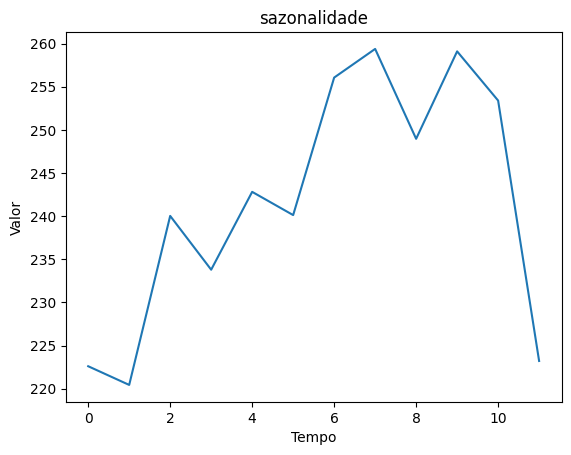

,sazonalidade
sazonalidade,
0,222.603825
1,220.438650
2,240.029525
3,233.793550
4,242.816650
5,240.124700
6,256.062200
7,259.384450
8,248.964900


In [34]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [35]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Santa Catarina - IDH,Santa Catarina - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Santa Catarina - Desemprego,Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,sazonalidade,Santa Catarina - Consumo de Cimento (t)
0,2003-1,0.797768,0.311113,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.256606,20.216800,1.320065e+08,6.638363e+06,19.725168,1.221860e+08,222.603825,142.456
1,2003-2,0.797853,0.312787,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.250731,19.631031,1.321743e+08,6.642080e+06,19.732277,1.222513e+08,220.438650,135.829
2,2003-3,0.797939,0.314207,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.244856,19.400920,1.323421e+08,6.645797e+06,19.739386,1.223166e+08,240.029525,133.135
3,2003-4,0.798024,0.315571,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.238982,19.153741,1.325098e+08,6.649513e+06,19.746495,1.223818e+08,233.793550,144.723
4,2003-5,0.798110,0.316880,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.233107,18.912155,1.326776e+08,6.653230e+06,19.753604,1.224471e+08,242.816650,150.523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,0.663849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.321494,NaN,NaN,NaN,NaN,259.384450,377.545
236,2022-9,NaN,0.663153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.790929,NaN,NaN,NaN,NaN,248.964900,370.282
237,2022-10,NaN,0.661797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.428377,NaN,NaN,NaN,NaN,259.101100,340.900
238,2022-11,NaN,0.660090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.448086,NaN,NaN,NaN,NaN,253.399900,363.900


In [36]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      134.837
1      136.495
2      154.807
3      146.582
4      149.537
        ...   
235        NaN
236        NaN
237        NaN
238        NaN
239        NaN
Name: Santa Catarina - Consumo de Cimento (t), Length: 240, dtype: float64

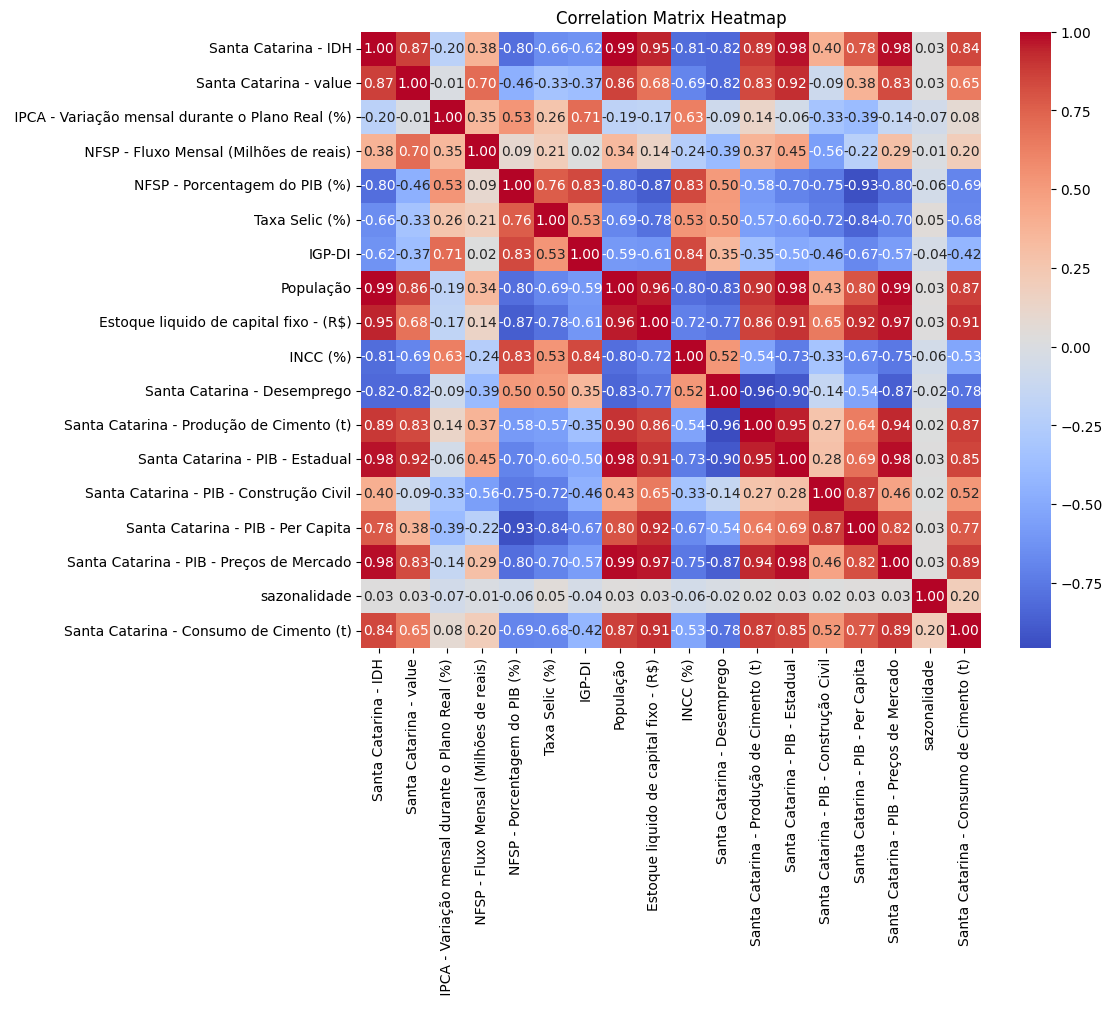

In [37]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [39]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Santa Catarina - IDH,4.229539e+06
1,Santa Catarina - value,8.599758e+04
2,IPCA - Variação mensal durante o Plano Real (%),1.372324e+03
3,NFSP - Fluxo Mensal (Milhões de reais),3.737489e+02
4,NFSP - Porcentagem do PIB (%),3.355780e+02
5,Taxa Selic (%),5.507583e+01
6,IGP-DI,4.470265e+02
7,População,3.651553e+06
8,Estoque liquido de capital fixo - (R$),9.976308e+06
9,INCC (%),7.162977e+02


In [40]:
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 1


,Santa Catarina - IDH,Santa Catarina - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Santa Catarina - Desemprego,Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,sazonalidade
0,0.797768,0.311113,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.256606,20.216800,1.320065e+08,6.638363e+06,19.725168,222.603825
1,0.797853,0.312787,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.250731,19.631031,1.321743e+08,6.642080e+06,19.732277,220.438650
2,0.797939,0.314207,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.244856,19.400920,1.323421e+08,6.645797e+06,19.739386,240.029525
3,0.798024,0.315571,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.238982,19.153741,1.325098e+08,6.649513e+06,19.746495,233.793550
4,0.798110,0.316880,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.233107,18.912155,1.326776e+08,6.653230e+06,19.753604,242.816650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.806494,0.528337,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,5.462946,119.903316,1.591779e+08,6.747095e+06,20.050324,259.384450
176,0.806418,0.529349,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,5.453853,119.416618,1.591753e+08,6.748100e+06,20.050719,248.964900
177,0.806343,0.530555,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,5.444760,119.349729,1.591727e+08,6.749105e+06,20.051115,259.101100
178,0.806267,0.531549,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,5.435667,119.499010,1.591701e+08,6.750110e+06,20.051511,253.399900


In [41]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Santa Catarina - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Santa Catarina - Desemprego,Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita
0,-0.990172,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,1.022276,-1.089782,-1.632756,-2.407230,-2.916306
1,-0.968008,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,1.017717,-1.101735,-1.614317,-2.350669,-2.845007
2,-0.949211,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,1.013158,-1.106430,-1.595879,-2.294107,-2.773708
3,-0.931162,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,1.008599,-1.111474,-1.577440,-2.237546,-2.702409
4,-0.913831,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,1.004040,-1.116404,-1.559002,-2.180984,-2.631110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.885029,-1.429358,0.425789,-0.584804,-1.503380,-0.514871,1.368581,0.605679,-1.872446,-1.145825,0.944353,1.353666,-0.752538,0.344857
176,1.898418,-1.523783,0.339575,-0.580461,-0.733634,-0.473208,1.380202,0.591420,-1.876611,-1.152882,0.934422,1.353380,-0.737241,0.348826
177,1.914388,-1.578548,0.160702,-0.571531,-0.323353,-0.484199,1.391823,0.577161,-1.875135,-1.159939,0.933057,1.353094,-0.721944,0.352794
178,1.927548,-1.597335,0.244264,-0.555524,0.132757,-0.359568,1.403443,0.562902,-1.942040,-1.166996,0.936103,1.352808,-0.706646,0.356763


In [42]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Santa Catarina - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Santa Catarina - Desemprego,Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita
0,-0.990172,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,1.022276,-1.089782,-1.632756,-2.407230,-2.916306
1,-0.968008,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,1.017717,-1.101735,-1.614317,-2.350669,-2.845007
2,-0.949211,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,1.013158,-1.106430,-1.595879,-2.294107,-2.773708
3,-0.931162,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,1.008599,-1.111474,-1.577440,-2.237546,-2.702409
4,-0.913831,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,1.004040,-1.116404,-1.559002,-2.180984,-2.631110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.754894,-0.960452,1.465326,-0.676734,0.472779,-1.087000,1.228701,0.759879,-1.491033,-1.008391,0.924705,1.323874,-0.732184,0.229847
164,1.768757,-1.007966,1.351131,-0.668750,0.302784,-0.904679,1.240408,0.749001,-1.525186,-1.025999,0.920746,1.330233,-0.757671,0.247293
165,1.781979,-0.976556,1.143146,-0.657609,0.339539,-0.900134,1.252114,0.738124,-1.546744,-1.043606,0.915830,1.336592,-0.783158,0.264738
166,1.794541,-1.146834,1.542609,-0.647588,0.472795,-1.136836,1.263821,0.727246,-1.586381,-1.061213,0.917899,1.342951,-0.808645,0.282184


In [43]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      134.837
1      136.495
2      154.807
3      146.582
4      149.537
        ...   
163    277.811
164    235.885
165    272.671
166    278.592
167    214.658
Name: Santa Catarina - Consumo de Cimento (t), Length: 168, dtype: float64

In [44]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [45]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 14)

In [46]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Santa Catarina - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Santa Catarina - Desemprego,Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita
132,0.777464,1.530065,0.817451,-0.366715,-0.530011,0.174628,0.848407,0.965586,-0.066954,-1.107914,1.296447,1.013389,0.277788,0.695420
133,0.817882,1.649361,1.130195,-0.350285,-0.532694,0.240832,0.861179,0.962419,-0.130652,-1.089733,1.292985,1.025595,0.249595,0.655953
134,0.861362,1.622916,1.160498,-0.335122,-0.186421,0.176857,0.873950,0.959252,-0.079602,-1.071553,1.278904,1.037800,0.221401,0.616486
135,0.905210,1.581460,1.131990,-0.321950,-0.719664,-0.005233,0.886722,0.956085,-0.034473,-1.053372,1.263823,1.050006,0.193208,0.577018
136,0.949431,1.638292,1.384387,-0.302995,-0.798520,0.097576,0.899493,0.952918,-0.177535,-1.035191,1.247844,1.062211,0.165014,0.537551
137,0.991276,1.643773,1.375487,-0.290554,-0.612129,0.431487,0.912265,0.949751,-0.208868,-1.017010,1.230915,1.074416,0.136821,0.498084
138,1.030636,1.704584,1.438928,-0.281926,-0.476740,0.482414,0.925036,0.946584,-0.245300,-0.998829,1.213294,1.086622,0.108627,0.458617
139,1.075615,1.841703,1.569590,-0.275931,-0.211736,0.657043,0.937808,0.943417,-0.333490,-0.980648,1.194877,1.098827,0.080434,0.419149
140,1.120867,1.837218,1.584058,-0.271466,-0.484608,0.678386,0.950580,0.940250,-0.296846,-0.962467,1.175612,1.111033,0.052240,0.379682
141,1.166449,1.797860,1.166380,-0.273241,-0.183907,0.727143,0.963351,0.937082,-0.292462,-0.944286,1.155747,1.123238,0.024046,0.340215


In [47]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 14)

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(144, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    mape = np.mean(df_results["Error"])/np.mean(df_results["Target"])

    return df_results, predictions, mape

In [51]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions, mape = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(f"\n\Results: {i} ___________________________________________\n")
            display(df_results.T)
            display(mape)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [52]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[2196081674, 574569208, 2848134794, 3411915391, 3814436359, 1386896531, 3002701990, 3239210430, 3077140386, 3054538001]


Step: 0 ___________________________________________
val_loss: 788.7152099609375
winner_seed: 2196081674


Step: 1 ___________________________________________
val_loss: 1152.00927734375


Step: 2 ___________________________________________
val_loss: 719.02880859375
winner_seed: 2848134794


Step: 3 ___________________________________________
val_loss: 747.7612915039062


Step: 4 ___________________________________________
val_loss: 766.44140625


Step: 5 ___________________________________________
val_loss: 696.638671875
winner_seed: 1386896531


Step: 6 ___________________________________________
val_loss: 920.0152587890625


Step: 7 ___________________________________________
val_loss: 741.4485473632812


Step: 8 ___________________________________________
val_loss: 682.5179443359375
winner_seed: 3077140386


Step: 9 ___________________________________________
val_

'\n\\Results: 0 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,249.339462,251.148285,252.429688,249.90329,249.143051,247.648438,245.86412,249.723694,249.78035,253.690125,252.372604,248.248718
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,3.360535,5.002289,3.443314,23.395721,21.774948,8.956573,57.66188,49.560303,34.769638,53.885864,28.944382,22.015717


0.09600017086464924

[1193350039, 3407366677, 2666630414, 3884484994, 1483057881, 2902346626, 3211093705, 1553041572, 329728455, 4274208645]


Step: 0 ___________________________________________
val_loss: 789.9713134765625
winner_seed: 1193350039


Step: 1 ___________________________________________
val_loss: 727.5667724609375
winner_seed: 3407366677


Step: 2 ___________________________________________
val_loss: 760.8984375


Step: 3 ___________________________________________
val_loss: 784.2964477539062


Step: 4 ___________________________________________
val_loss: 755.6126098632812


Step: 5 ___________________________________________
val_loss: 701.77685546875
winner_seed: 2902346626


Step: 6 ___________________________________________
val_loss: 670.4310302734375
winner_seed: 3211093705


Step: 7 ___________________________________________
val_loss: 712.4309692382812


Step: 8 ___________________________________________
val_loss: 890.1553344726562


Step: 9 ___________________________________________


'\n\\Results: 1 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,257.703918,260.849792,256.50174,257.703094,260.204926,266.055206,265.963043,265.137543,267.049988,264.086639,266.036438,267.990479
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,5.003922,14.703796,0.628738,15.595917,10.713074,9.450195,37.562958,34.146454,17.5,43.489349,15.280548,41.757477


0.07545438868613123

[1790283615, 131767998, 2045913563, 3815374895, 3471499191, 381948159, 3158526080, 1032616461, 1996663097, 2431977020]


Step: 0 ___________________________________________
val_loss: 709.6071166992188
winner_seed: 1790283615


Step: 1 ___________________________________________
val_loss: 899.9056396484375


Step: 2 ___________________________________________
val_loss: 708.5762329101562
winner_seed: 2045913563


Step: 3 ___________________________________________
val_loss: 696.9680786132812
winner_seed: 3815374895


Step: 4 ___________________________________________
val_loss: 756.2384643554688


Step: 5 ___________________________________________
val_loss: 867.923828125


Step: 6 ___________________________________________
val_loss: 1439.927978515625


Step: 7 ___________________________________________
val_loss: 720.5457763671875


Step: 8 ___________________________________________
val_loss: 767.5657958984375


Step: 9 ___________________________________________
val_loss: 1208.332885

'\n\\Results: 2 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,239.037888,241.060226,242.316299,243.315018,244.925171,245.548401,246.191254,248.395767,251.015793,254.03038,256.234314,256.429077
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,13.662109,5.08577,13.556702,29.983994,25.992828,11.05661,57.334747,50.888229,33.534195,53.545609,25.082672,30.196075


0.1074022908015977

[1022188125, 2408732460, 3787632921, 1674630915, 2271114550, 2206171312, 2884720453, 2728031524, 2933517494, 3136489811]


Step: 0 ___________________________________________
val_loss: 858.0134887695312
winner_seed: 1022188125


Step: 1 ___________________________________________
val_loss: 724.9352416992188
winner_seed: 2408732460


Step: 2 ___________________________________________
val_loss: 813.8162841796875


Step: 3 ___________________________________________
val_loss: 770.2623291015625


Step: 4 ___________________________________________
val_loss: 619.9684448242188
winner_seed: 2271114550


Step: 5 ___________________________________________
val_loss: 1059.2587890625


Step: 6 ___________________________________________
val_loss: 807.0266723632812


Step: 7 ___________________________________________
val_loss: 771.447265625


Step: 8 ___________________________________________
val_loss: 721.3001098632812


Step: 9 ___________________________________________
val_loss: 1007.431945

'\n\\Results: 3 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,261.974091,271.241028,253.708496,252.955185,262.333801,263.276947,243.429764,266.733459,260.310974,256.711609,248.728333,255.71431
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,9.274094,25.095032,2.164505,20.343826,8.584198,6.671936,60.096237,32.550537,24.239014,50.86438,32.588654,29.481308


0.09267993646202516

[295953199, 181649966, 2208268105, 340720363, 3012154293, 3622222205, 2417073654, 3891562911, 55529092, 2078548018]


Step: 0 ___________________________________________
val_loss: 771.5013427734375
winner_seed: 295953199


Step: 1 ___________________________________________
val_loss: 724.1692504882812
winner_seed: 181649966


Step: 2 ___________________________________________
val_loss: 752.3162231445312


Step: 3 ___________________________________________
val_loss: 5443.58740234375


Step: 4 ___________________________________________
val_loss: 712.1519775390625
winner_seed: 3012154293


Step: 5 ___________________________________________
val_loss: 856.5866088867188


Step: 6 ___________________________________________
val_loss: 775.5032348632812


Step: 7 ___________________________________________
val_loss: 749.5247802734375


Step: 8 ___________________________________________
val_loss: 792.1710815429688


Step: 9 ___________________________________________
val_loss: 921.825866699

'\n\\Results: 4 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,260.61554,269.988251,266.344025,267.3237,268.585022,269.027649,255.522278,270.584625,270.285034,269.900269,270.410217,269.931061
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,7.915543,23.842255,10.471024,5.975311,2.332977,12.422638,48.003723,28.699371,14.264954,37.67572,10.906769,43.698059


0.07556977002807339

[970589459, 3562806766, 1506408296, 1237221638, 1810176763, 1622310216, 3114656794, 3829039357, 3881112458, 3896605013]


Step: 0 ___________________________________________
val_loss: 747.2046508789062
winner_seed: 970589459


Step: 1 ___________________________________________
val_loss: 719.0784301757812
winner_seed: 3562806766


Step: 2 ___________________________________________
val_loss: 751.2741088867188


Step: 3 ___________________________________________
val_loss: 693.9700317382812
winner_seed: 1237221638


Step: 4 ___________________________________________
val_loss: 49125797888.0


Step: 5 ___________________________________________
val_loss: 715.0657958984375


Step: 6 ___________________________________________
val_loss: 876.8975219726562


Step: 7 ___________________________________________
val_loss: 821.4066772460938


Step: 8 ___________________________________________
val_loss: 767.1148071289062


Step: 9 ___________________________________________
val_loss: 771.3688354

'\n\\Results: 5 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,250.672516,250.163361,250.362991,251.582214,251.385956,250.666107,245.170929,249.834457,250.457916,250.444565,248.502579,249.52034
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,2.027481,4.017365,5.51001,21.716797,19.532043,5.938904,58.355072,49.449539,34.092072,57.131424,32.814407,23.287338


0.09633819379748462

[2942156099, 3592018116, 3864617439, 2394212276, 844875153, 2173601204, 2595033800, 3497755751, 2723499400, 956042606]


Step: 0 ___________________________________________
val_loss: 768.1262817382812
winner_seed: 2942156099


Step: 1 ___________________________________________
val_loss: 720.9698486328125
winner_seed: 3592018116


Step: 2 ___________________________________________
val_loss: 781.2201538085938


Step: 3 ___________________________________________
val_loss: 1062.5941162109375


Step: 4 ___________________________________________
val_loss: 864.8426513671875


Step: 5 ___________________________________________
val_loss: 791.7438354492188


Step: 6 ___________________________________________
val_loss: 717.8327026367188
winner_seed: 2595033800


Step: 7 ___________________________________________
val_loss: 1534.064453125


Step: 8 ___________________________________________
val_loss: 960.7052001953125


Step: 9 ___________________________________________
val_loss: 797.44775

'\n\\Results: 6 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,249.815872,250.631577,250.266815,250.223663,250.346741,250.665588,249.81044,250.102615,249.633911,221.953079,210.940094,241.616241
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,2.884125,4.48558,5.606186,23.075348,20.571259,5.939423,53.715561,49.181381,34.916077,85.62291,70.376892,15.38324


0.11410525549200888

[2044253554, 2737827289, 2581718629, 44173172, 59273565, 3750569329, 2820410886, 1444211145, 2685206544, 1923416299]


Step: 0 ___________________________________________
val_loss: 747.8485107421875
winner_seed: 2044253554


Step: 1 ___________________________________________
val_loss: 3310592196608.0


Step: 2 ___________________________________________
val_loss: 825.1038818359375


Step: 3 ___________________________________________
val_loss: 692.9841918945312
winner_seed: 44173172


Step: 4 ___________________________________________
val_loss: 772.3196411132812


Step: 5 ___________________________________________
val_loss: 649.7323608398438
winner_seed: 3750569329


Step: 6 ___________________________________________
val_loss: 930.4332885742188


Step: 7 ___________________________________________
val_loss: 855.8989868164062


Step: 8 ___________________________________________
val_loss: 776.6813354492188


Step: 9 ___________________________________________
val_loss: 5474968.0
1/1

'\n\\Results: 7 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,251.925934,243.56134,240.173569,246.554504,243.451218,238.021652,246.641891,239.749603,244.258591,249.142975,253.181793,261.444366
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,0.774063,2.584656,15.699432,26.744507,27.466782,18.583359,56.884109,59.534393,40.291397,58.433014,28.135193,35.211365


0.11367072081565174

[1354203608, 1792074416, 17288147, 707358258, 1813693684, 1508311810, 1565743515, 1034299141, 2319856533, 732913268]


Step: 0 ___________________________________________
val_loss: 673.2220458984375
winner_seed: 1354203608


Step: 1 ___________________________________________
val_loss: 758.9102783203125


Step: 2 ___________________________________________
val_loss: 670.6948852539062
winner_seed: 17288147


Step: 3 ___________________________________________
val_loss: 853.0103149414062


Step: 4 ___________________________________________
val_loss: 758.2569580078125


Step: 5 ___________________________________________
val_loss: 786.2647705078125


Step: 6 ___________________________________________
val_loss: 608.5211181640625
winner_seed: 1565743515


Step: 7 ___________________________________________
val_loss: 731.7307739257812


Step: 8 ___________________________________________
val_loss: 777.2957763671875


Step: 9 ___________________________________________
val_loss: 712.1265869

'\n\\Results: 8 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,261.572327,270.19577,266.175476,266.585724,4.081036,3.387291,3.775978,3.398649,3.808214,3.170403,3.848977,3.32424
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,8.87233,24.049774,10.302475,6.713287,266.836975,253.217712,299.750031,295.885345,280.74176,304.405579,277.468018,222.908768


0.690955574187662

[2382667041, 1578903298, 3429688857, 271487333, 1985504893, 1334881161, 2014830156, 1687101887, 994983336, 3424264485]


Step: 0 ___________________________________________
val_loss: 932.5070190429688
winner_seed: 2382667041


Step: 1 ___________________________________________
val_loss: 726.7239990234375
winner_seed: 1578903298


Step: 2 ___________________________________________
val_loss: 1778.514892578125


Step: 3 ___________________________________________
val_loss: 743.52294921875


Step: 4 ___________________________________________
val_loss: 814.4179077148438


Step: 5 ___________________________________________
val_loss: 1193.960693359375


Step: 6 ___________________________________________
val_loss: 2343.120849609375


Step: 7 ___________________________________________
val_loss: 911.2159423828125


Step: 8 ___________________________________________
val_loss: 764.6243286132812


Step: 9 ___________________________________________
val_loss: 787.01513671875
1/1 [============

'\n\\Results: 9 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,250.875687,260.288391,250.07341,253.363754,257.34552,260.797302,244.441971,267.932556,262.871552,254.973297,258.006775,252.734314
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,1.82431,14.142395,5.799591,19.935257,13.572479,4.192291,59.08403,31.35144,21.678436,52.602692,23.310211,26.501312


0.08409827352590424

'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,253.353317,256.912781,252.835281,253.951004,229.180222,229.509476,224.681152,231.159302,230.94722,227.810349,226.826218,230.695312
Target,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,0.653317,10.766781,3.037719,19.347996,41.737778,27.095524,78.844848,68.124698,53.60278,79.765651,54.490782,4.462312


In [53]:
display(mae)
display(mape)

237.3218

0.12809763519171966